In [16]:
import pymc as pm
import arviz as az
import jax.numpy as jnp
import numpy as np
import aesara.tensor as at
from timing import timing_van_jax, comp_gen_D
from modules.polyfit import Polyfit
import json

dummy_fits = Polyfit('dummy_data/fits.npz', input_h5='dummy_data/inputdata.h5', order=3, covariance=True)
coeff = np.array(dummy_fits.p_coeffs)
cov = np.array(dummy_fits.cov)
sd_coeff = np.sqrt(np.diagonal(np.array(cov), axis1=1, axis2=2))
sd_coeff[np.where(sd_coeff==0)]=0.00000001
deg=3

#Import target data
with open("dummy_data/target_data.json", 'r') as f:
    target_data = json.loads(f.read())
target_values = np.array([target_data[k][0] for k in target_data])
target_error = np.array([target_data[k][1] for k in target_data])
target_error[np.where(target_error==0)]=0.00000001


param_guess = np.array([2, -1])
comp = np.array(comp_gen_D(param_guess.size, deg))


with pm.Model() as model:
    p = pm.Normal('params', param_guess, sigma=5, shape=np.shape(param_guess))
    #p_poly = pm.Deterministic('p_poly', tt.prod(tt.power(p, comp[:, np.newaxis]), axis=2, no_zeros_in_input=True))
    
    true_coeff = pm.Normal('true_coeff', 0, sigma=20, shape=np.shape(coeff))
    likelihood_coeff = pm.Normal('x', mu=true_coeff, sigma=sd_coeff, observed=coeff)

    true_y = at.dot(true_coeff, at.prod(at.power(p, comp[:, np.newaxis]), axis=2, no_zeros_in_input=True)).flatten()
    likelihood_y = pm.Normal('y', mu=true_y, sigma=target_error, observed=target_values)

    map_start = pm.find_MAP()
    step = pm.NUTS(max_treedepth=20, scaling=map_start)
    trace = pm.sample(40, step, tune=100, initvals=map_start)

    



Fitting observables:  ['/func0', '/func1']


Only 40 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [params, true_coeff]
INFO:pymc:NUTS: [params, true_coeff]


Sampling 4 chains for 100 tune and 40 draw iterations (400 + 160 draws total) took 654 seconds.
INFO:pymc:Sampling 4 chains for 100 tune and 40 draw iterations (400 + 160 draws total) took 654 seconds.
/tmp/ipykernel_14982/2015817217.py:41: UserWarning: The number of samples is too small to check convergence reliably.
  trace = pm.sample(40, step, tune=100, initvals=map_start)


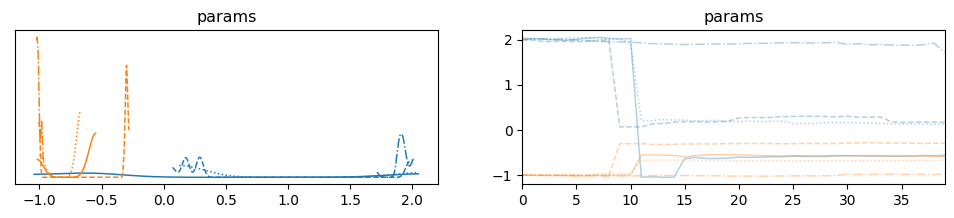

In [17]:
with model:
    az.plot_trace(trace, var_names='params')
    #az.plot_trace(trace, var_names='true_coeff')

In [19]:

"""chain_count = trace.get_values('params').shape[0]
y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model)
data_spp = az.from_pymc3(trace=trace, posterior_predictive=y_pred_g)

posterior_params = az.plot_posterior(data_spp, var_names='params', hdi_prob=.95, point_estimate='mean', textsize=20, round_to=4)"""
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
params[0],0.825,1.062,-0.607,2.045,0.369,0.275,13.0,14.0,1.48
params[1],-0.728,0.273,-1.023,-0.296,0.101,0.075,7.0,14.0,2.49
"true_coeff[0, 0]",7.432,14.616,-26.271,29.108,0.876,0.908,353.0,182.0,1.05
"true_coeff[0, 1]",1.638,17.934,-28.942,35.442,0.955,1.689,353.0,150.0,1.10
"true_coeff[0, 2]",-13.310,15.390,-40.842,15.835,1.111,0.908,203.0,101.0,1.01
...,...,...,...,...,...,...,...,...,...
"true_coeff[39, 5]",0.000,0.000,-0.000,0.000,0.000,0.000,162.0,95.0,1.04
"true_coeff[39, 6]",0.000,0.000,-0.000,0.000,0.000,0.000,292.0,56.0,1.01
"true_coeff[39, 7]",-0.000,0.000,-0.000,0.000,0.000,0.000,145.0,119.0,1.03
"true_coeff[39, 8]",0.000,0.000,-0.000,0.000,0.000,0.000,121.0,63.0,1.01


In [13]:
p = np.array([1.7, -1.1])
ppoly = np.prod(np.power(p, comp[:, np.newaxis]), axis=2)

y_test = np.dot(coeff, ppoly).flatten()
y_test

array([ 2.52016904e+00,  2.71289422e+00,  3.18039907e+00,  3.96657913e+00,
        3.59322222e+00,  4.11549484e+00,  4.01689136e+00,  3.30343798e+00,
        2.63367937e+00,  2.56086647e+00,  1.87919754e+00,  1.40906992e+00,
        1.03110195e+00,  7.16870738e-01,  4.83734123e-01,  2.50959737e-01,
        1.88127676e-01,  9.34527835e-02,  5.28182149e-02,  2.31283209e-02,
        2.67967415e+00,  3.86748408e+00,  4.47718448e+00,  4.72478416e+00,
        6.92252465e+00,  5.75558934e+00,  5.33826511e+00,  3.62213325e+00,
        2.26485923e+00,  1.12976266e+00,  5.77058655e-01,  1.77958655e-01,
        4.23533946e-02,  8.54697609e-03,  2.33694203e-03,  3.43442150e-04,
       -3.37218607e-06,  7.15163784e-05,  0.00000000e+00,  0.00000000e+00])

In [14]:
from aesara import function
p = at.vector('p')
z_test = at.dot(coeff, at.prod(at.power(p, comp[:, np.newaxis]), axis=2, no_zeros_in_input=True)).flatten()

f = function([p], z_test)
f(np.array([1.7, -1.1]))

array([ 2.52016904e+00,  2.71289422e+00,  3.18039907e+00,  3.96657913e+00,
        3.59322222e+00,  4.11549484e+00,  4.01689136e+00,  3.30343798e+00,
        2.63367937e+00,  2.56086647e+00,  1.87919754e+00,  1.40906992e+00,
        1.03110195e+00,  7.16870738e-01,  4.83734123e-01,  2.50959737e-01,
        1.88127676e-01,  9.34527835e-02,  5.28182149e-02,  2.31283209e-02,
        2.67967415e+00,  3.86748408e+00,  4.47718448e+00,  4.72478416e+00,
        6.92252465e+00,  5.75558934e+00,  5.33826511e+00,  3.62213325e+00,
        2.26485923e+00,  1.12976266e+00,  5.77058655e-01,  1.77958655e-01,
        4.23533946e-02,  8.54697609e-03,  2.33694203e-03,  3.43442150e-04,
       -3.37218607e-06,  7.15163784e-05,  0.00000000e+00,  0.00000000e+00])